In [1]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
from math import sqrt,pi
import matplotlib.pyplot as plt
from ecell4.extra import ensemble
import numpy as np
from math import pi

def wrap(job,job_id,task_id):
    def singlerun(kf,c0,L,run,duration,pa,K):
        import numpy as np
        import math
        from math import sqrt,pi
        D=1.
        ka = kf*D
        kd = ka/K
        gamma=0.5772157
        rm = 0.005
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))
        f = 1.#.0208582;
        if pa=='new':
            f=1.0208582
        PP=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)        
        Pa= 1./(1+(sqrt(3)/2/pi)*(np.log(f*f/12)+(4*pi*D/ka)-2*gamma))            
        voxelr=rm*f
        td =(2*voxelr)**2/(4*D)
        H = 3*voxelr*2
        ori = Real3(0.5*H,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)        
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),voxelr,rng)        
        lx,ly,lz=w.actual_lengths()
        Area=ly*lz
        NB=int(c0*Area)
        NA=int(NB/30)
        c0a= NB/Area
        sinf=kd/(kd+c0a*ka)
        if pa=='new':
            ka = PP*D/factor   
            kap = 2*sqrt(3)*Pa*D
            kd = kap/K
            sinf=kd/(kd+c0a*kap)
        w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))            
        with species_attributes():
            A |  {'D': str(0), 'radius':str(voxelr),'location':'M'}
            B |  {'D': str(D), 'radius':str(voxelr),'location':'M'}
            C |  {'D': str(0), 'radius':str(voxelr),'location':'M'}

        with reaction_rules():#for spa and egfrd
            A + B == C | (ka,kd)
        m2 = get_model()
        w.bind_to(m2)
        
        w.add_molecules(Species('A'), NA)
        w.add_molecules(Species('B'), NB)
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        obs = FixedIntervalNumberObserver(td,['A'])
        sim.run(duration,obs)
        tlogs,nlog=np.array(obs.data()).T   
        if run==1:
            if pa=='new':
                print('NA={},NB={},ka={:.3f},kd={:.3f},voxelr={:.4f},td={},Area={:.3f}'.format(NA,NB,kap,kd,voxelr,td,Area))
                print('kratio={:.3f},c0L={:.3f},sinf{},eqna{}'.format(kap/kd,NB/Area,sinf,sinf*NA))
            else:
                print('NA={},NB={},ka={:.3f},kd={:.3f},voxelr={:.4f},td={},Area={:.3f}'.format(NA,NB,ka,kd,voxelr,td,Area))
                print('kratio={:.3f},c0L={:.3f},sinf{},eqna{}'.format(ka/kd,NB/Area,sinf,sinf*NA))                
        return 
    job.update({'run':task_id})
    out=singlerun(**job)
    return out

L=6.5
K=0.1
nb=400
c0= nb/L/L
simrun=2000
result = []
res = []
pa='new'
print(c0,L*L)

No module named 'pint' required by 'ecell4.extra.unit'


9.467455621301776 42.25


6.771
/home/chew/outputdata/2ndpaper/rerxn_st_kf=0.1new
/home/chew/outputdata/2ndpaper/re_st_kf0.1N400kratio0.1.csv
6.7285
/home/chew/outputdata/2ndpaper/rerxn_st_kf=100new
/home/chew/outputdata/2ndpaper/re_st_kf100N400kratio0.1.csv


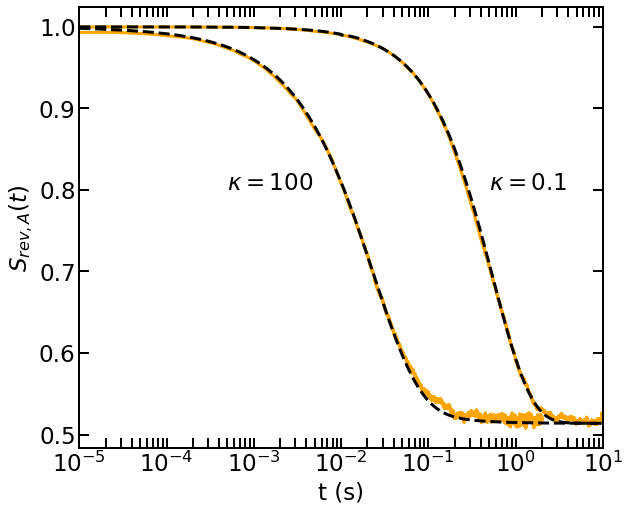

In [8]:
fig,ax=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=16
lw=3
for kf in [0.1,100]:    
    name = '/home/chew/outputdata/2ndpaper/rerxn_st_kf={}{}'.format(kf,pa)
    X,Y = np.loadtxt(name,delimiter=',')        
    y0=Y[0]
    print(Y[-1])
    print(name)
    plt.plot(X,Y/y0,'orange',label='Sim. ($\\kappa={}$)'.format(kf),linewidth=lw)
    name = '/home/chew/outputdata/2ndpaper/re_st_kf{}N400kratio{}.csv'.format(kf,K)
    print(name)
    T,ST = np.loadtxt(name,delimiter=',').T   
    plt.semilogx(T,ST,'k--',label='Theory ($\\kappa={}$)'.format(kf),linewidth=lw)

ax.set_xlabel('t (s)',fontsize=fs)
ax.set_ylabel('$S_{rev,A}(t)$',fontsize=fs)
ax.set_xlim(T[0],T[-1])
ax.tick_params(labelsize=fs)
ax.text(0.5e-3,0.8,'$\\kappa=100$',fontsize=fs)
ax.text(0.5,0.8,'$\\kappa=0.1$',fontsize=fs)
fig.tight_layout(pad=0)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='both',which='both',direction='in',length=10,width=2)
